In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from wordcloud import WordCloud
import re

"Libraries to help with jupyter notebook usage"
# Increases jupyter notebook display width
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from IPython.display import Image # Helps display images in notebook

In [2]:
"Import python util functions"
import jupyternotebook_utils as jp

## Data Import
Import files containing information regarding tracks from over 10,000 playlists in terms of audio featuers and various details such as global popularity and release date

#### Dataset from million playlist dataset

In [3]:
audio_features_df = []
track_details_df = []

for i in range(10):
    audio_features_file_path = f'../data/processed_data/audio_features/audio_features-{i*1000}-{(i+1)*1000 - 1}.csv'
    df = pd.read_csv(audio_features_file_path)
    audio_features_df.append(df)
    
    track_details_file_path = f'../data/processed_data/playlist_details/details-{i*1000}-{(i+1)*1000 - 1}.csv'
    df = pd.read_csv(track_details_file_path)
    track_details_df.append(df)

audio_features_df = pd.concat(audio_features_df, ignore_index=True)
track_details_df = pd.concat(track_details_df, ignore_index=True)

original_track_details_df = track_details_df.copy()
original_audio_features_df = audio_features_df.copy()

#### Dataset of tracks from every genre and their audio features

In [4]:
audio_features_by_genre_file_path = f'../data/processed_data/genres/audio_features_by_genre.csv'
audio_features_by_genre_df = pd.read_csv(audio_features_by_genre_file_path)

clustered_audio_features_by_genre_file_path = f'../data/processed_data/genres/audio_features_by_genre.csv'

## 2. Data Pre-processing
1. Remove irrelevant columns such as key and duration
2. Remove outliers for each audio features in `audio_features_df`
3. Combining `audio_features_df` and `track_details_df` for easy data manipulation
4. Perform One-Hot-Encoding (OHE) for `track_popularity` and `release_date` in `track_details_df`

## Utility for Pre-processing
Declaration of constants and functions to be used for data pre-processing

In [ ]:
before_graph_audio_features_df = audio_features_df.copy()
after_graph_audio_features_df = audio_features_df.copy()

audio_features_list = 1

num_bins = 250

graph_height = 4
graph_width = 4

audio_features_list = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence']

def plot_graph(plot_title, graph_height, graph_width, graph_features_list = audio_features_list, graph_df = before_graph_audio_features_df):
    graph_height = graph_height
    graph_width = graph_width
    graph_count = len(graph_features_list)

    fig, axes = plt.subplots(1, graph_count, figsize=(graph_width * graph_count, graph_height))
    fig.suptitle(plot_title, fontsize=16)
    
    for i, audio_feature in enumerate(graph_features_list, start = 0):
        ax = axes[i]
        ax.hist(graph_df[audio_feature], bins=num_bins, range=(0, 1), edgecolor='none')
        ax.set_title(f'{str(audio_feature).capitalize()}')
        ax.set_xlabel(f'{audio_feature.capitalize()}')
        ax.set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 2.1 Removing Irrelevant Columns
Columns such as `key` and `duration` do not provide useful insights to the analysis, hence they are removed.

For now, `instrumentalness` seems to have a large number of null values, it will be dropped too to prevent messing up the recommendation system.

In [ ]:
audio_features_df = original_audio_features_df.drop(columns=['key', 'duration_ms', 'instrumentalness'])

### 2.2 Removing outliers from audio features
Despite the official Spotify API Documentation mentioning that most audio features are within the range of 0 to 1, a simple `track_details_df.describe()` shows its definitely not the case. To better visualize each audio feature's distribution, let's plot them out:

In [ ]:
graph_title = 'Frequency Histograms of Audio Features'
plot_graph(graph_title, graph_height, graph_width, audio_features_list)

It's immediately noticeable that only audio features `Danceability`, `Energy`, and `Valence` are "normal" (excuse the pun). The distribution of `Loudness` is also noticeably messy due to its range of [-60, 0], let's fix that using min-max normalization. 

In [ ]:
max_loudness = 0
min_loudness = -60
after_graph_audio_features_df['loudness'] = audio_features_df['loudness']
after_graph_audio_features_df['normalized_loudness'] = (audio_features_df['loudness'] - min_loudness) / (max_loudness - min_loudness)

features_list = ['loudness', 'normalized_loudness']

graph_title = 'Frequency Histograms of Loudness Before vs After Normalization'

plot_graph(graph_title, graph_height, graph_width, features_list, after_graph_audio_features_df)

before_graph_audio_features_df['loudness'] = after_graph_audio_features_df['normalized_loudness']
after_graph_audio_features_df = before_graph_audio_features_df.copy()

Another quite obvious issue is with the `instrumentalness` column, which for some reason contains a large amount of null values.


NOTE: since instrumentalness seems to have large amounts of null values, it will be dropped for now.

In [ ]:
# graph_count = 2

# fig, axes = plt.subplots(1, graph_count, figsize=(graph_width * graph_count, graph_height))
# fig.suptitle('Frequency Histograms of Instrumentalness Before vs After Normalization', fontsize=16)

# instrumentalness = audio_features_df['instrumentalness']
# filtered_instrumentalness = instrumentalness[instrumentalness > 0].apply(lambda x : x * 10000)

# columns_list = [instrumentalness, filtered_instrumentalness]

# for i, columns in enumerate(columns_list):
#     ax = axes[i]

#     ax.hist(columns, bins=num_bins, range=(0, 1), edgecolor='none')
#     ax.set_xlabel('Instrumentalness')
#     ax.set_ylabel('Frequency')
    
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

Looks so much better. Now that we know `Loudness` is heavily left-skewed, while `Speechiness`, `Acousticness` and `Liveness` are heavily right-skewed, we can perform square-transformation and square-root-transformation to them respectively.

In [ ]:
# for left-skewed, use cube-normalization
after_graph_audio_features_df['loudness'] = before_graph_audio_features_df['loudness'].apply(lambda x : x**3)

# for right-skewed, use square-root-normalization
non_zero_columns = ['speechiness', 'acousticness', 'liveness']
for column in non_zero_columns:
    after_graph_audio_features_df[column] = before_graph_audio_features_df[column].apply(lambda x : np.sqrt(x))

    
# Printing before and after graph
features_list = ['loudness','speechiness', 'acousticness', 'liveness']

graph_title_before = 'Frequency Histogram of Skewed Audio Features Before Normalizing'
plot_graph(graph_title_before, graph_height, graph_width, features_list, before_graph_audio_features_df)

    
graph_title_after = 'Frequency Histogram of Skewed Audio Features After Normalizing'
plot_graph(graph_title_after, graph_height, graph_width, features_list, after_graph_audio_features_df)

graph_audio_features_df = after_graph_audio_features_df.copy()
audio_features_df = after_graph_audio_features_df.copy()

Although several audio features are yet to be close to normal, it is still way better than where we started from. Here's the final frequency histograms for every audio feature after various normalization techniques have been applied

In [ ]:
graph_title = 'Original Frequency Histogram of Audio Features'
plot_graph(graph_title, graph_height, graph_width, audio_features_list, original_audio_features_df)

graph_title = 'Frequency Histograms of Audio Features'
plot_graph(graph_title, graph_height, graph_width, audio_features_list, audio_features_df)

### 2.3 Combining audio_features_df and track_details_df

Due to some issues with spotify's song database, the audio_features for all songs still remain in the DB (presumably for song analysis purpose), but the track details (allbum, date of release, artist) have been removed. 

This caused quite a headache and took quite a long time to realize the issue, but alast it has been fixed, the rows with such missing data has been labelled as NA during the data retrieval process, for simple data pre-processing.

The `merged_df` now contains information from `audio_features_df` as well as `track_details_df`, joined on the track id

In [ ]:
merged_df = audio_features_df.merge(track_details_df, on='id', how='inner')

tracks_with_missing_details = merged_df.loc[merged_df['track_uri'].isna(), 'id']

merged_df = merged_df.drop(index=merged_df[merged_df['id'].isin(tracks_with_missing_details)].index)

### 2.4 One-Hot-Encoding (OHE) for `track_popularity` and `release_date` in `track_details_df`
One-Hot Encoding (OHE) is used to convert categorical variables into a binary format, where each category is represented by a separate binary feature, making the data suitable for machine learning algorithms that require numerical inputs. Here's how we will be performing OHE:
- OHE for `track_popularity` can be done by grouping them into buckets of their nearest 10s
- OHE for `release_date` can be done by grouping them into the year released 

In [ ]:
original_merged_df = merged_df.copy()

merged_df['release_date'] = original_merged_df['release_date'].apply(lambda date_str: date_str.split('-')[0] if isinstance(date_str, str) and '-' in date_str else date_str)

merged_df['track_popularity'] = original_merged_df['track_popularity'].apply(lambda popularity: (int(popularity // 10) * 10) if not pd.isna(popularity) else popularity)

# Data Visualization
## Scatter Plot 
Allows better visualization of how one audio feature tends to affect the rest

In [ ]:
num_rows = 1
num_cols = len(audio_features_list)

subplot_size = 5
fig_row_size = subplot_size * num_cols
fig_col_size = subplot_size

for af in audio_features_list:
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(fig_row_size, fig_col_size))
    
    for i, feature in enumerate(audio_features_list):
        axs[i].hexbin(x=audio_features_df[af], y=audio_features_df[feature], alpha=1, gridsize=25, cmap='terrain')
        
        axs[i].set_xlabel(af)
        axs[i].set_ylabel(feature)
        
        # Adding linear regression line
        slope, intercept = np.polyfit(audio_features_df[af], audio_features_df[feature], 1)
        x_values = [audio_features_df[af].min(), audio_features_df[af].max()]
        y_values = [slope * x + intercept for x in x_values]
        axs[i].plot(x_values, y_values, color='red', linewidth=2)
    
    plt.tight_layout()
    plt.savefig(f"../resources/audio_feature_plots/plot_{af}.png", format="png", dpi=30)
    plt.show()

## Correlation Matrix
Overview of the correlation between audio features (note: correlation need not necessarily imply causation)

In [ ]:
correlation_matrix = audio_features_df[audio_features_list].corr()

# Create a mask to hide the lower triangle (including the diagonal)
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

# Plotting the correlation matrix as a heatmap, showing only the values in the upper triangle
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0, mask=~mask)
plt.title("Correlation Matrix of Audio Features")
plt.savefig(f"../resources/audio_feature_plots/correlation.png", format="png", dpi=50)
plt.show()

## Audio Feature Trend Over the Years
Here's how the audio_features change over time

In [ ]:
trend_analysis_df = original_merged_df.copy()

trend_analysis_df = trend_analysis_df.dropna(subset=['release_date'])
selected_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence', 'release_date']
trend_analysis_df = trend_analysis_df[selected_columns]

trend_analysis_df['release_date'] = pd.to_datetime(trend_analysis_df['release_date'], errors='coerce')

trend_analysis_df['release_year'] = trend_analysis_df['release_date'].dt.to_period('Q').astype(str)
trend_analysis_df['release_year'] = trend_analysis_df['release_year'].apply(lambda x: x.replace('Q1', 'H1').replace('Q2', 'H1').replace('Q3', 'H2').replace('Q4', 'H2'))

trend_analysis_df = trend_analysis_df.groupby('release_year').mean().reset_index()

subplots_per_row = 2
num_rows = len(audio_features_list) // subplots_per_row + (len(audio_features_list) % subplots_per_row > 0)
fig, axes = plt.subplots(nrows=num_rows, ncols=subplots_per_row, figsize=(25, 6 * num_rows))
axes = axes.flatten()

for i, audio_feature in enumerate(audio_features_list):

    ax = axes[i]
    ax.plot(trend_analysis_df.index, trend_analysis_df[audio_feature], label=audio_feature)
    
    ax.set_xlabel('Song Release Year')
    ax.set_title(f'{audio_feature.capitalize()} Over The Years')
    ax.grid(True)

#     # x_ticks: how often a label is drawn, x_labels: what the label is
#     x_ticks = trend_analysis_df.index[::120]
#     x_labels = [date.split("-")[0] for date in trend_analysis_df['release_year_month'][::120]]
#     ax.set_xticks(x_ticks)
#     ax.set_xticklabels(x_labels, rotation=45)

plt.tight_layout()
plt.show()

## Genre Clustering Word Based
Clusters genres obtained from Spotify API using kmeans algorithm

In [ ]:
from constants import global_genres as definitions

# Convert the preprocessed definitions to TF-IDF vectors
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(definitions)

# Use K-means clustering to group similar definitions
num_clusters = 15
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(tfidf_matrix)

cluster_labels = kmeans.labels_

# Concatenate definitions for each cluster without the cluster labels
clusters = {}
for i, label in enumerate(cluster_labels):
    if label not in clusters:
        clusters[label] = []
    # Remove the [Cluster X] [X] annotations from the definitions
    clean_definition = ' '.join([word for word in definitions[i].split() if not word.startswith('[')])
    # Remove all numbers from the clean_definition using regex
    clean_definition = re.sub(r'\d+', '', clean_definition).replace(']', '')
    clusters[label].append(clean_definition)

### Cluster Based Word Cloud
Clustering genres based on definitions

In [ ]:
# Generate word clouds for each cluster
for label, cluster_definitions in clusters.items():
    all_definitions = ' '.join(cluster_definitions)
    word_list = all_definitions.split()
    # covert to set to remove duplicates
    unique_words = list(set(word_list))  
    unique_definitions = ' '.join(unique_words)

    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(unique_definitions)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {label}')
    plt.savefig(f"../resources/wordclouds/cluster_{label}.png", format="png", dpi=50)
    plt.show()

### Overall Word Cloud
Word cloud based on frequency of words in each genre

In [ ]:
# Generate word clouds for each cluster and get word frequencies
word_frequencies = {}
for label, cluster_definitions in clusters.items():
    all_definitions = ' '.join(cluster_definitions)
    word_list = all_definitions.split()
    for word in word_list:
        if word in word_frequencies:
            word_frequencies[word] += 1
        else:
            word_frequencies[word] = 1

# Generate the large word cloud with overlapping clusters
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_frequencies)

# Display the large word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Overall Word Cloud')
plt.savefig(f"../resources/wordclouds/overall.png", format="png", dpi=50)
plt.show()

In [ ]:
# Temporary example to display the usage of cosine_similarity

from sklearn.metrics.pairwise import cosine_similarity

# Audio feature vectors for two tracks (8-dimensional)
track1_features = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
track2_features = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.2, 0.3])

# Reshape feature vectors to be 2D arrays (1 row, 8 columns)
track1_features = track1_features.reshape(1, -1)
track2_features = track2_features.reshape(1, -1)

# Calculate cosine similarity
similarity = cosine_similarity(track1_features, track2_features)

print("Cosine Similarity:", similarity[0][0])

## Genre Clustering Using KMeans Algorithm

Here's an overview of the whole clustering process:
1. Identifying the optimal value of K for the Partitioning Clustering using the Elbow Method.
2. Run Kmeans algorithm using the optimal K value.
3. For each cluster, re-run Elbow Method to find the optimal K value for Hierachial Subclustering.

### Constant Declarations for KMeans Algorithm

In [5]:
from IPython.display import clear_output # clears output for better logging
from sklearn.cluster import KMeans
from collections import Counter # used to count frequency of genres in each cluster

min_clusters = 1
max_clusters = 11

audio_feature_columns = ['danceability', 'energy', 'key', 'loudness', 'speechiness',
                   'acousticness', 'instrumentalness', 'liveness', 'valence',
                   'tempo', 'duration_ms']

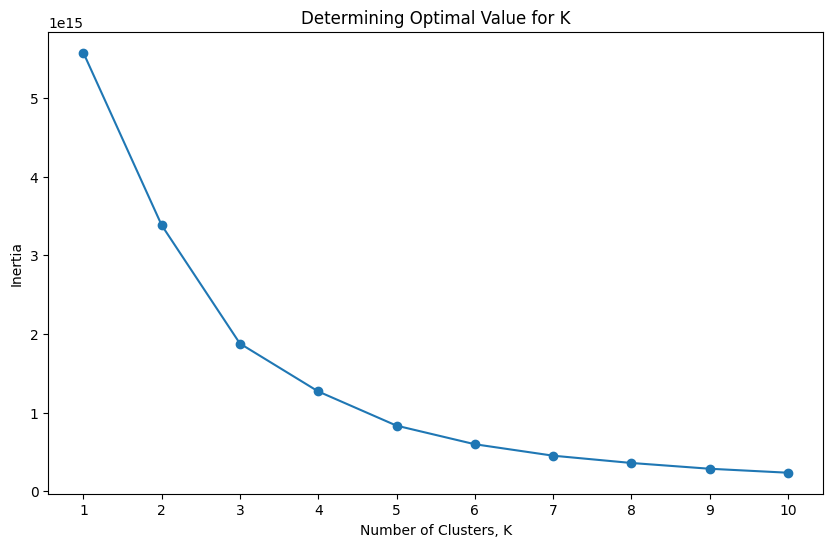

In [6]:
X = audio_features_by_genre_df.iloc[:, 4:]
inertia_values = []

for k in range(min_clusters, max_clusters):
    
    status = f'Attempting Cluster Size: {k}'
    print(status, end='\r')  # '\r' moves the cursor to the beginning of the same line, effectively overwriting previous line
    
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(X)
    inertia_values.append(kmeans_model.inertia_)

clear_output(wait=True)

plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters), inertia_values, marker='o')
plt.title('Determining Optimal Value for K')
plt.xlabel('Number of Clusters, K')
plt.ylabel('Inertia')
plt.xticks(range(min_clusters, max_clusters))
plt.show()

In [14]:
audio_features_kmeans_df = audio_features_by_genre_df.copy()

X = audio_features_kmeans_df.iloc[:, 4:]

num_clusters = 7
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_model.fit(X)

audio_features_kmeans_df['cluster'] = kmeans_model.labels_
audio_features_kmeans_df.sort_values(by='cluster', inplace=True)

selected_columns = ['genre', 'cluster', 'track_name', 'track_uri']
selected_df = audio_features_kmeans_df[selected_columns]
clustered_audio_features_by_genre_file_path = '../data/processed_data/genres/clustered_audio_features_by_genre.csv'
selected_df.to_csv(clustered_audio_features_by_genre_file_path, index=False)

print(f'Sorted and selected data with cluster assignments written to {clustered_audio_features_by_genre_file_path}')

Sorted and selected data with cluster assignments written to ../data/processed_data/genres/clustered_audio_features_by_genre.csv


In [8]:
# Removed for now, to idenfity top 20 genres in each cluster

# from collections import Counter

# # Group the DataFrame by 'cluster' and aggregate genres
# clustered_genre_groups = selected_df.groupby('cluster')['genre'].apply(lambda x: list(x))

# for cluster, genres in clustered_genre_groups.items():
#     genre_counter = Counter(genres)
#     most_common_genres = genre_counter.most_common(20)
    
#     print(f"Cluster {cluster}:")
#     for genre, count in most_common_genres:
#         print(f"  {genre}: {count}")
#     print()

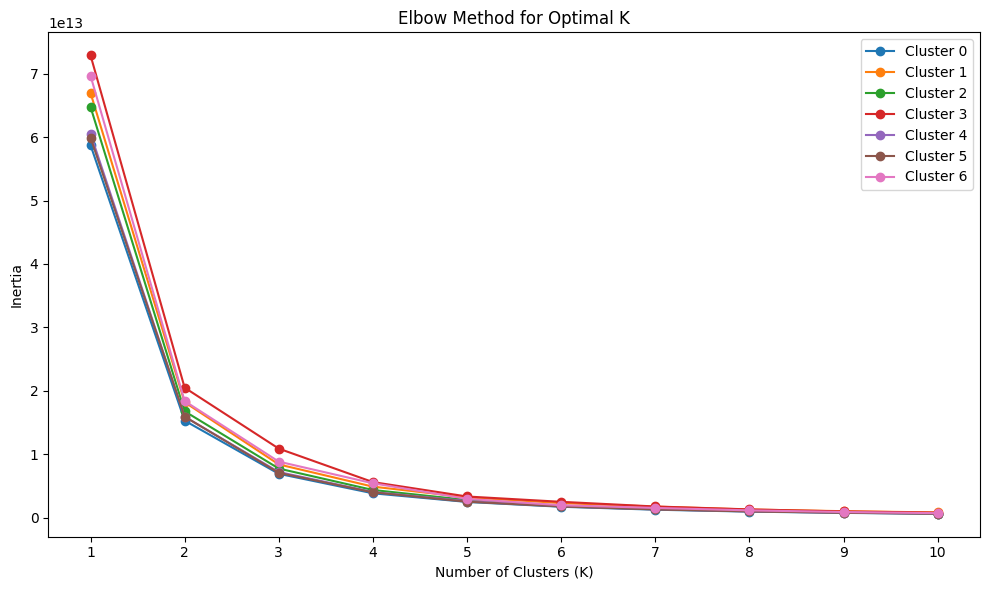

In [9]:
unique_clusters = audio_features_kmeans_df['cluster'].unique()

plt.figure(figsize=(10, 6))

for cluster in unique_clusters:
    status = f'Finding optimal K for Cluster {cluster}'
    print(status)
    
    # Filter data for the current cluster
    cluster_data = audio_features_kmeans_df[audio_features_kmeans_df['cluster'] == cluster]
    X = cluster_data.loc[:, audio_feature_columns]

    # Perform the elbow method to find the optimal K value
    inertia_values = []
    
    for k in range(min_clusters, max_clusters):
        status = f'Attempting Cluster Size: {k}'
        print(status, end='\r')
        
        kmeans_model = KMeans(n_clusters=k, random_state=42)
        kmeans_model.fit(X)
        inertia_values.append(kmeans_model.inertia_)

    clear_output(wait=True)
    
    # Plot the elbow method results for each cluster on the same chart
    plt.plot(range(min_clusters, max_clusters), inertia_values, marker='o', label=f'Cluster {cluster}')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.xticks(range(min_clusters, max_clusters))
    plt.legend()

plt.tight_layout()
plt.show()

In [15]:
num_subclusters = 5

audio_features_kmeans_df['subcluster'] = None # Create an empty column for subclusters

# Iterate through each unique cluster label
for cluster in audio_features_kmeans_df['cluster'].unique():
    status = f'Processing Subclustering for Cluster {cluster}'
    print(status, end='\r')
    
    cluster_data = audio_features_kmeans_df[audio_features_kmeans_df['cluster'] == cluster]

    X_subcluster = cluster_data.loc[:, audio_feature_columns] # clusters based on audio_features only, NOT cluster/subcluster value

    # Perform subclustering for the current cluster
    kmeans_subcluster = KMeans(n_clusters=num_subclusters, random_state=42)
    kmeans_subcluster.fit(X_subcluster)
    
    # Update subcluster labels using .loc accessor
    audio_features_kmeans_df.loc[audio_features_kmeans_df['cluster'] == cluster, 'subcluster'] = kmeans_subcluster.labels_

audio_features_kmeans_df.sort_values(by=['cluster', 'subcluster'], inplace=True)

selected_columns = ['genre', 'cluster', 'subcluster', 'track_name', 'track_uri']
audio_features_kmeans_df[selected_columns].to_csv(clustered_audio_features_by_genre_file_path, index=False)

print("All subclustering processes completed.")

All subclustering processes completed.


In [16]:
audio_features_kmeans_df = pd.read_csv(clustered_audio_features_by_genre_file_path)

audio_features_kmeans_df['genre_cluster'] = audio_features_kmeans_df['cluster'].astype(str) + ', ' + audio_features_kmeans_df['subcluster'].astype(str)

audio_features_kmeans_df.to_csv(clustered_audio_features_by_genre_file_path, index=False)

print("Added 'genre_cluster' column and saved to CSV.")

Added 'genre_cluster' column and saved to CSV.


In [40]:
sample_track = [{'id': '37eUMVeDxKdIxFt6pzHhZN', 'danceability': 0.389, 'energy': 0.122, 'key': 9, 'loudness': -16.369, 'speechiness': 0.0643, 'acousticness': 0.987, 'instrumentalness': 0.0541, 'liveness': 0.0858, 'valence': 0.692, 'tempo': 181.091, 'duration_ms': 3148774}]

audio_features = sample_track[0]
sample_track_audio_features = [
    audio_features['danceability'],
    audio_features['energy'],
    audio_features['key'],
    audio_features['loudness'],
    audio_features['speechiness'],
    audio_features['acousticness'],
    audio_features['instrumentalness'],
    audio_features['liveness'],
    audio_features['valence'],
    audio_features['tempo'],
    audio_features['duration_ms']
]

# Reshape the audio feature vector to match the input format
sample_track_audio_features = [sample_track_audio_features]

# Predict the cluster and subcluster for the sample track's audio features
print(sample_track_audio_features)
predicted_cluster = kmeans_model.predict(sample_track_audio_features)
predicted_subcluster = kmeans_subcluster.predict(sample_track_audio_features)  # Use the appropriate subcluster model

print(f"Sample track belongs to Cluster {predicted_cluster[0]}, Subcluster {predicted_subcluster[0]}")

[[0.389, 0.122, 9, -16.369, 0.0643, 0.987, 0.0541, 0.0858, 0.692, 181.091, 3148774]]
Sample track belongs to Cluster 3, Subcluster 4


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
